In [1]:
import sys
sys.path.append("../../dataprocessing")
import numpy as np
import os
import PIL
import PIL.Image
from PIL import ImageDraw
import tensorflow as tf
# import tensorflow_datasets as tfds
import pandas as pd
from tqdm import tqdm
import random
import data_process
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.spatial import distance

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
import datetime as dt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from xgboost import XGBRegressor

## 함수 정의

In [2]:
cd ../

c:\Users\jongm\Desktop\MINI\projects\Facial-Expression-Recognition\modeling


In [200]:
def cal_dist(data):
    landmark_matrixs, landmark_matrixs_df = [], []
    lp = [point[:-1] for point in data.columns if '-' in point]
    set_lp = sorted(set(lp), key = lambda x: lp.index(x))
    for idx, row in data.iterrows():
        temp_list = []
        len_x = row['right'] - row['left']
        len_y = row['bottom'] - row['top']
        for i in range(len(set_lp)):
            temp_list.append([(row[set_lp[i]+'x'] - row['left']) / len_x, (row[set_lp[i]+'y'] - row['top']) / len_y])
            # temp_list.append([row[set_lp[i]+'x'], row[set_lp[i]+'y']])
        temp = pd.DataFrame(distance.cdist(temp_list, temp_list, metric='euclidean'), index=set_lp, columns=set_lp)
        landmark_matrixs.append(temp)
        landmark_matrixs_df.append(temp.to_numpy()[np.triu_indices(len(set_lp), 1)])
    return landmark_matrixs, pd.DataFrame(landmark_matrixs_df)

In [4]:
def show_img(data, path, landmark_points):    
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # img = cv2.imread(path, cv2.IMREAD_COLOR)    
    drawing_image = img.copy()
    target_landmark = landmark_points.index
    # print(landmark_points.index)
    # print(data)
    for idx in range(0,len(data.columns),2):
        radius = 2
        x = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx]]
        y = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx+1]]
        # if data.columns[idx] == 'frame':
        #     continue
        if data.columns[idx][:-1] in target_landmark:
            # print(x,y)
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius*2, color=(255,255,0), thickness=-1, lineType=cv2.LINE_AA)
        else:
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius, color=(0,255,0), thickness=-1, lineType=cv2.LINE_AA)
    # img_show(drawing_image)
    left = data.loc[int(float(path.split('/')[4][:-4]))]['left']
    top = data.loc[int(float(path.split('/')[4][:-4]))]['top']
    right = data.loc[int(float(path.split('/')[4][:-4]))]['right']
    bottom = data.loc[int(float(path.split('/')[4][:-4]))]['bottom']
    plt.subplots(figsize=(10,10))
    # cv2.rectangle(drawing_image, (int(left), int(top)), (int(right), int(bottom)), (255, 255, 0), 3)
    plt.imshow(cv2.cvtColor(drawing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [5]:
def show_diff(*args):
    data = args[0]
    window = args[1]
    erase_list = ['frame','left','top','right','bottom','time_diff']
    data3 = data[[point for point in data.columns if '-' in point] + erase_list]

    if len(args) == 3:
        idxs = args[2]
        i = 0
        for idx in idxs:
            if i == 0:
                data2 = data[[point for point in data.columns if str(idx) == point.split('-')[0]]]
            else:
                data2 = pd.concat([data2, data[[point for point in data.columns if str(idx) == point.split('-')[0]]]], axis=1)
            i += 1
        data2 = pd.concat([data2, data[erase_list]], axis=1)
        # print(data2.columns)
    else:
        data2 = data3.copy()

    # print(list(set(data.columns) - set(erase_list)))
    remain_list = sorted(list(set(data2.columns) - set(erase_list)))
    diff_df = pd.DataFrame(columns=list(range(len(data2))), index=list(set([c[:-1] for c in remain_list])))

    # print(data2, remain_list)    
    for row in range(0, len(remain_list), 2):
        init_point = [data2.iloc[0][remain_list[row]], data2.iloc[0][remain_list[row+1]]]
        # print(remain_list[col], remain_list[col+1])
        temp2 = 0.0
        # diff_df[remain_list[col][:-1]] = 0
        for col in range(len(data2)):    
            # print(init_point, data.loc[col][remain_list[row]], data.loc[col][remain_list[row+1]])    
            temp = distance.euclidean(init_point, [data2.loc[col][remain_list[row]], data2.loc[col][remain_list[row+1]]])
            temp2 += temp
            # for start in range(0,len(data.index), window):
            #     # print(max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col]), max(data.iloc[start:start+5][col]), min(data.iloc[start:start+5][col]))
            #     temp += max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col])
            diff_df.at[remain_list[row][:-1], col] = temp
        diff_df.at[remain_list[row][:-1], 'sum'] = temp2
        # print(remain_list[col] + ", "+ remain_list[col+1])
    return diff_df.sort_values('sum', ascending=False), data3

In [6]:
def make_flow_chart(data, diff_df, part, order, image_order, path):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize = (20,10))
    # sort = diff_df.iloc[:order]
    # print(diff_df)
    if type(order) == int:        
        diff_df = diff_df.drop(['sum'], axis=1)
        new_data = diff_df.iloc[:order]
    elif type(order) == list:
        diff_df = diff_df.drop(['class'], axis=1)
        new_data = diff_df[order]
        new_data = new_data.transpose()
    # print(new_data.index)
    # new_data = new_data[[point for point in new_data.columns if str(part) == point.split('-')[0]]]
    temp_plot = sns.lineplot(data = new_data.transpose(), markers=False, dashes=False)  
    # print(path+str(image_order) + '.0.jpg')
    show_img(data, path + str(image_order) + '.0.jpg', new_data)
    # ax[idx, col].set_title(str(idx) +" 번 클러스터")
    # if col==0:        
    #     ax[idx, col].set_ylabel(list(custom_sort.keys())[idx])
    #     ax[idx, col].yaxis.label.set_size(20)
    # ax[idx].set_ylabel(list(custom_sort.keys())[idx] + " group")
    # ax[idx].set_xticks(list(range(1,len(seq)+1)))        
    # for row in data.iterrows():
    #     ax[idx].text(row[0], int(row[1]['quiz']), int(row[1]['quiz']), fontsize=12, ha='center') 
    #     ax[idx].text(row[0], int(row[1]['proj']), int(row[1]['proj']), fontsize=12, ha='center')

In [7]:
def predict(data_path1, data_path2, model):
    landmarks = pd.read_csv(data_path1)
    landmarks2 = pd.read_csv(data_path2)
    landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
    landmark_matrixs_df['class'] = 0.0
    landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
    landmark_matrixs_df2['class'] = 1.0
    df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
    length_i = len(landmark_matrixs[0].columns)
    start = 1
    name_list = []
    for i in landmark_matrixs[0].index:
        for j in range(start, length_i):
            name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
        start += 1

    X = df.drop(['class'], axis=1)
    X = X.astype('float')
    y = df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

    if model == 'rf':
        set_model = RandomForestRegressor(bootstrap=True, random_state=2022, oob_score=True)
    elif model == 'xgboost':
        set_model = XGBRegressor(use_label_encoder=False, eval_metric='mlogloss')

    set_model.fit(X_train, y_train)
    pred = set_model.predict(X_test)
    # print(confusion_matrix(y_test, pred))    
    print('훈련세트 정확도: {:.3f}' .format(set_model.score(X_train, y_train)))
    print('테스트세트 정확도: {:.3f}' .format(set_model.score(X_test, y_test)))
    importance = pd.DataFrame({'landmarks': name_list, 'importance': set_model.feature_importances_})
    importance = importance.sort_values('importance',ascending=False)
    importance = importance.astype({'landmarks':'str'})
    print(importance)
    return landmarks2, importance

In [8]:
def show_img(data, path, landmark_points):    
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # img = cv2.imread(path, cv2.IMREAD_COLOR)    
    drawing_image = img.copy()
    target_landmark = landmark_points.index
    # print(landmark_points.index)
    # print(data)
    for idx in range(0,len(data.columns),2):
        radius = 2
        x = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx]]
        y = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx+1]]
        if data.columns[idx] == 'frame':
            continue
        cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius, color=(0,255,0), thickness=-1, lineType=cv2.LINE_AA)
        # if data.columns[idx][:-1] in target_landmark:
        #     # print(x,y)
        #     cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius*2, color=(255,255,0), thickness=-1, lineType=cv2.LINE_AA)
        # else:
    for point_pair in landmark_points:
        x1 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[0]+'x']
        y1 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[0]+'y']
        x2 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[1]+'x']
        y2 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[1]+'y']
        cv2.line(drawing_image, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), radius)
    # img_show(drawing_image)
    left = data.loc[int(float(path.split('/')[4][:-4]))]['left']
    top = data.loc[int(float(path.split('/')[4][:-4]))]['top']
    right = data.loc[int(float(path.split('/')[4][:-4]))]['right']
    bottom = data.loc[int(float(path.split('/')[4][:-4]))]['bottom']
    plt.subplots(figsize=(10,10))
    # cv2.rectangle(drawing_image, (int(left), int(top)), (int(right), int(bottom)), (255, 255, 0), 3)
    plt.imshow(cv2.cvtColor(drawing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [277]:
def cal_score(new_inputs, importt):
    sum_score = []
    def each_score(order,x):
        if landmark_matrixs_df[order].mean() > landmark_matrixs_df2[order].mean():
            zerocls = landmark_matrixs_df[order].max()
            onecls = landmark_matrixs_df2[order].min()
        else:
            zerocls = landmark_matrixs_df[order].min()
            onecls = landmark_matrixs_df2[order].max()
        y = (1/(onecls - zerocls))*(x - zerocls)
        # print(y)
        if y > 1:
            return 1
        elif y < 0:
            return 0
        else:
            return y
    for i in range(importt):
        order = name_list.index(importance.iloc[i]['landmarks'])
        new_input = new_inputs[order]
        sum_score.append(each_score(order, new_input))
        print(order, each_score(order, new_input))
        # sum_score += each_score(order, new_input)
    # return sum_score / len(range(16))
    # print(sum_score)
    return np.mean(sum_score)

In [278]:
def cal_score_test(new_inputs, importt):
    sum_score = []
    def each_score(order,x):
        if landmark_matrixs_df[order].mean() > landmark_matrixs_df2[order].mean():
            zerocls = landmark_matrixs_df[order].max()
            onecls = landmark_matrixs_df2[order].min()
        else:
            zerocls = landmark_matrixs_df[order].min()
            onecls = landmark_matrixs_df2[order].max()
        y = (1/(onecls - zerocls))*(x - zerocls)
        # print(y)
        if y > 1:
            return 1
        elif y < 0:
            return 0
        else:
            return y
    for i in range(importt):
        order = name_list.index(importance_points[i])
        new_input = new_inputs[order]
        sum_score.append(each_score(order, new_input))
        print(order, each_score(order, new_input))
        # sum_score += each_score(order, new_input)
    # return sum_score / len(range(16))
    # print(sum_score)
    return np.mean(sum_score)

> 0은 얼굴 테두리 \
> 1, 2는 왼쪽 눈썹 위, 아래 \
> 3, 4는 오른쪽 눈썹 위, 아래 \
> 5, 6은 왼쪽, 오른쪽 눈 \
> 7, 8은 위쪽 입술 윗부분, 아래부분 \
> 9, 10은 아래쪽 입술 윗부분, 아래부분 \
> 11은 코 세로축 \
> 12는 코 아래부분

## 눈 깜빡 감기

In [279]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/눈깜빡감기+1/202209.21211216911.csv', 'rf')

훈련세트 정확도: 0.995
테스트세트 정확도: 0.975
        landmarks  importance
5324   3-3 ↔ 6-10        0.03
5804   4-4 ↔ 6-13        0.03
5645    4-2 ↔ 6-9        0.02
5486    4-0 ↔ 6-9        0.02
5491   4-0 ↔ 6-14        0.02
...           ...         ...
2922   0-24 ↔ 4-4        0.00
2921   0-24 ↔ 4-3        0.00
2920   0-24 ↔ 4-2        0.00
2919   0-24 ↔ 4-1        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


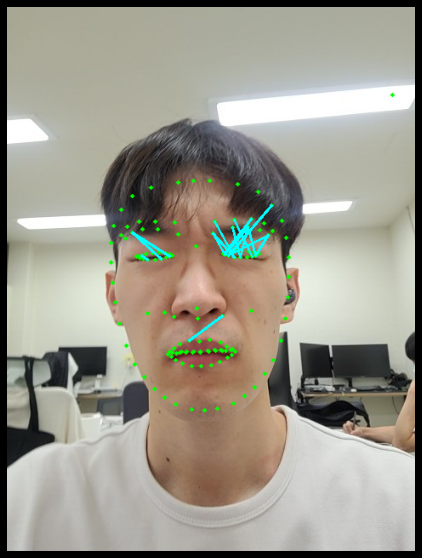

In [280]:
face = '눈깜빡감기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:16]['landmarks']]
image_order = 20
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [281]:
## xgb_reg
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/눈깜빡감기+1/202209.21211216911.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

rf_cls = RandomForestRegressor(bootstrap=True, random_state=2022, oob_score=True)

rf_cls.fit(X_train, y_train)
pred = rf_cls.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(rf_cls.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rf_cls.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': rf_cls.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
# test_df = pd.read_csv('../data/images/입벌리기+0.5/202209.15190045957.csv')
# landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
# landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
# print([format(x, '.8f') for x in xgb_reg.predict(landmark_matrixs_df_test)])

훈련세트 정확도: 0.995
테스트세트 정확도: 0.975
        landmarks  importance
5324   3-3 ↔ 6-10        0.03
5804   4-4 ↔ 6-13        0.03
5645    4-2 ↔ 6-9        0.02
5486    4-0 ↔ 6-9        0.02
5491   4-0 ↔ 6-14        0.02
...           ...         ...
2922   0-24 ↔ 4-4        0.00
2921   0-24 ↔ 4-3        0.00
2920   0-24 ↔ 4-2        0.00
2919   0-24 ↔ 4-1        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


In [240]:
# importance_points = ['3-4 ↔ 6-15', '3-3 ↔ 6-13', '3-2 ↔ 6-11', '3-1 ↔ 6-10', '3-0 ↔ 6-8',
#                     '1-0 ↔ 5-15', '1-1 ↔ 5-13', '1-2 ↔ 5-11', '1-3 ↔ 5-10', '1-4 ↔ 5-8']

In [284]:
importance_points = ['0-0 ↔ 6-15', '0-1 ↔ 6-13', '0-2 ↔ 6-11', '0-3 ↔ 6-10', '0-4 ↔ 6-8',
                     '0-31 ↔ 5-15', '0-32 ↔ 5-13', '0-33 ↔ 5-11', '0-34 ↔ 5-10', '0-35 ↔ 5-8']

importance_landmark = pd.DataFrame(columns=['from', 'to', 'a', 'b', '운동이름'])

idx = 0
for i in importance_points:
    a_list = landmark_matrixs_df[name_list.index(i)]
    b_list = landmark_matrixs_df2[name_list.index(i)]
    if a_list.mean() > b_list.mean():
            a = a_list.max()
            b = b_list.min()
    else:
        a = a_list.min()
        b = b_list.max()
    landmark_from = i.split('↔')[0]
    landmark_to = i.split('↔')[1]
    importance_landmark.loc[idx] = [landmark_from, landmark_to, a, b, '눈깜빡감기']
    idx += 1

In [264]:
importance_landmark

,from,to,a,b,운동이름
0,0-0,6-15,0.399687,0.335968,눈깜빡감기
1,0-1,6-13,0.404032,0.330206,눈깜빡감기
2,0-2,6-11,0.374092,0.307623,눈깜빡감기
3,0-3,6-10,0.332697,0.274081,눈깜빡감기
4,0-4,6-8,0.251939,0.214232,눈깜빡감기
5,0-31,5-15,0.220694,0.172107,눈깜빡감기
6,0-32,5-13,0.298084,0.240316,눈깜빡감기
7,0-33,5-11,0.358580,0.291816,눈깜빡감기
8,0-34,5-10,0.373130,0.302967,눈깜빡감기
9,0-35,5-8,0.378366,0.312125,눈깜빡감기


In [288]:
cal_score(landmark_matrixs_df.iloc[0], 16)

5324 0.2812116228775206
5804 0.24098742657292682
5645 0.26943628411713494
5486 0.2912417156863159
5491 0.26073269780033664
5726 0.24104115772661405
5232 0.3177313214697035
5648 0.2691436953751004
603 0.08371088853357635
5806 0.35510704046971314
6013 0.21613804820486082
5409 0.23767215597502753
7995 0.30668065127397115
4707 0.26656335595045155
5651 0.34703750254116555
4705 0.2850778277931813


0.26684458702297503

In [287]:
cal_score_test(landmark_matrixs_df.iloc[0], 10)

86 0.260323806253479
215 0.20078888390948726
343 0.2282873421555466
471 0.22012388861058188
597 0.05766654206256723
3666 0.25613678766099746
3764 0.24987279106043314
3861 0.25988044909457253
3958 0.28994588607235366
4053 0.293598731631021


0.23166251085110398

In [242]:
test_landmark = pd.read_csv('../data/images/눈깜빡감기테스트/202209.27215153476.csv')
landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_landmark)
# landmark_matrixs_df_test['class'] = 1.0

86 0.7967817920382565
215 0.7789700948682788
343 0.7627563841263522
471 0.6661086185527009
597 0.609942919820415
3666 0.49879419333692837
3764 0.6124229104336636
3861 0.6923438493196827
3958 0.7441179141621906
4053 0.7104705620808285
0.6872709238739297


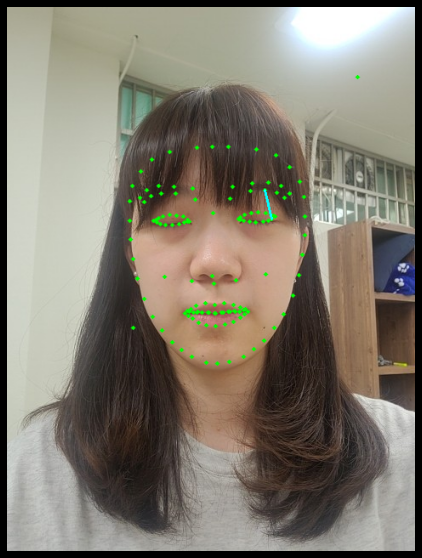

In [248]:
order = 17
print(cal_score(landmark_matrixs_df_test.iloc[order], 10))
face = '눈깜빡감기테스트'
diff_list_test, landmarks_cut_test = show_diff(test_landmark, 5)
diff_list_test = [x.split(' ↔ ') for x in importance.iloc[2:3]['landmarks']]
image_order = order
show_img(landmarks_cut_test, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list_test)

## 아랫입술내리기

훈련세트 정확도: 0.999
테스트세트 정확도: 0.999
        landmarks  importance
8680  10-1 ↔ 11-0        0.02
7995   7-4 ↔ 12-2        0.02
2311   0-18 ↔ 8-8        0.02
8536   9-2 ↔ 10-5        0.01
8392   8-5 ↔ 10-8        0.01
...           ...         ...
2921   0-24 ↔ 4-3        0.00
2920   0-24 ↔ 4-2        0.00
2919   0-24 ↔ 4-1        0.00
2918   0-24 ↔ 4-0        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


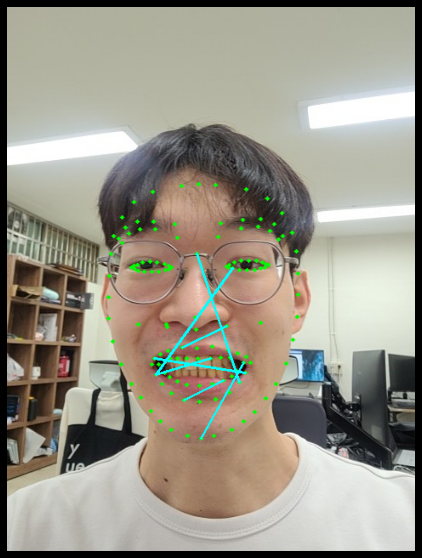

In [289]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/아랫입술내리기+1/202209.21212840986.csv', 'rf')
face = '아랫입술내리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:7]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [290]:
## xgb_reg
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/아랫입술내리기+1/202209.21212840986.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

rf_cls = RandomForestRegressor(bootstrap=True, random_state=2022, oob_score=True)

rf_cls.fit(X_train, y_train)
pred = rf_cls.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(rf_cls.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rf_cls.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': rf_cls.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
# test_df = pd.read_csv('../data/images/입벌리기+0.5/202209.15190045957.csv')
# landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
# landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
# print([format(x, '.8f') for x in xgb_reg.predict(landmark_matrixs_df_test)])

훈련세트 정확도: 0.999
테스트세트 정확도: 0.999
        landmarks  importance
8680  10-1 ↔ 11-0        0.02
7995   7-4 ↔ 12-2        0.02
2311   0-18 ↔ 8-8        0.02
8536   9-2 ↔ 10-5        0.01
8392   8-5 ↔ 10-8        0.01
...           ...         ...
2921   0-24 ↔ 4-3        0.00
2920   0-24 ↔ 4-2        0.00
2919   0-24 ↔ 4-1        0.00
2918   0-24 ↔ 4-0        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


In [291]:
cal_score(landmark_matrixs_df.iloc[0], 10)

8680 0.5476303922737096
7995 0.20511344624470546
2311 0.21887389128881923
8536 0.08792044159050985
8392 0.09376081806553223
7859 0.12390700779097673
7735 0.43466340007628634
3651 0.14679431362151024
8282 0.2315035799522665
6665 0.2059156491192175


0.22960829400235339

In [296]:
importance_points = ['10-0 ↔ 11-0', '10-2 ↔ 11-0', '10-8 ↔ 11-0', '10-6 ↔ 11-0', '10-2 ↔ 12-0',
                     '10-6 ↔ 12-2']
cal_score_test(landmark_matrixs_df2.iloc[0], len(importance_points))

In [299]:
for i in importance_points:
    a_list = landmark_matrixs_df[name_list.index(i)]
    b_list = landmark_matrixs_df2[name_list.index(i)]
    if a_list.mean() > b_list.mean():
            a = a_list.max()
            b = b_list.min()
    else:
        a = a_list.min()
        b = b_list.max()
    landmark_from = i.split('↔')[0]
    landmark_to = i.split('↔')[1]
    importance_landmark.loc[idx] = [landmark_from, landmark_to, a, b, '아랫입술내리기']
    idx += 1

In [173]:
test_landmark = pd.read_csv('../data/images/아랫입술내리기테스트/202209.27223205884.csv')
landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_landmark)
# landmark_matrixs_df_test['class'] = 1.0

8680 0.17317294701699656
659 -0.025020316829499407
8483 0.3576544375099812
5607 0.24127935153106664
6207 0.3344064170602143
107 0.01675267066049691
3917 0.15838654964123888
7873 0.8752023994196079
8102 0.43961236709734175
7219 0.3560035144220588
5841 0.23303799625106003
2603 0.24675124515625443
2463 0.13635588705837423
7548 0.20805483364119662
2000 0.4818637765515888
1571 0.028525299449960156
0.23715867389106332


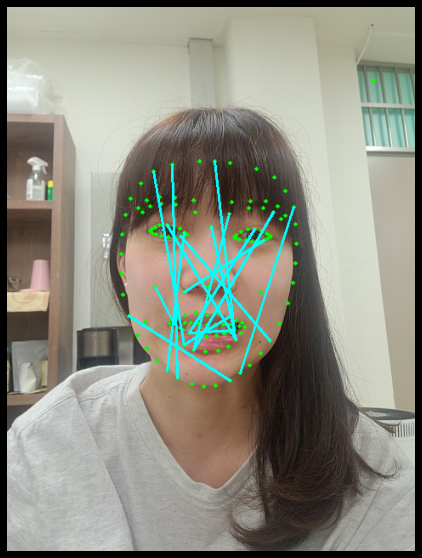

In [174]:
order = 13
print(cal_score(landmark_matrixs_df_test.iloc[order]))
face = '아랫입술내리기테스트'
diff_list_test, landmarks_cut_test = show_diff(test_landmark, 5)
diff_list_test = [x.split(' ↔ ') for x in importance.iloc[:16]['landmarks']]
image_order = order
show_img(landmarks_cut_test, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list_test)

## 눈썹올리기

훈련세트 정확도: 0.996
테스트세트 정확도: 0.990
        landmarks  importance
5151    3-1 ↔ 6-4        0.26
5068    3-0 ↔ 6-6        0.22
5483    4-0 ↔ 6-6        0.17
5067    3-0 ↔ 6-5        0.06
5150    3-1 ↔ 6-3        0.04
...           ...         ...
2921   0-24 ↔ 4-3        0.00
2920   0-24 ↔ 4-2        0.00
2919   0-24 ↔ 4-1        0.00
2918   0-24 ↔ 4-0        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


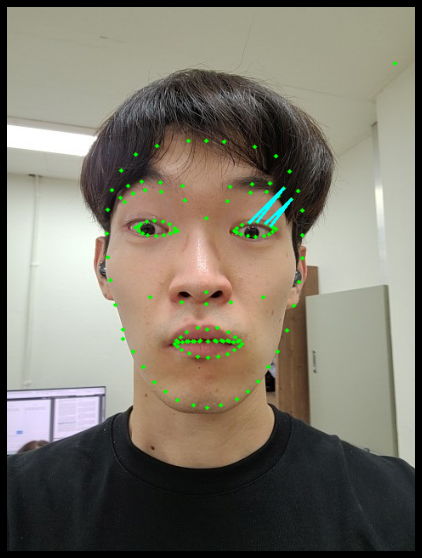

In [300]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/눈썹들어올리기+1/202209.06220402854.csv', 'rf')
face = '눈썹들어올리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [301]:
## xgb_reg
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/눈썹들어올리기+1/202209.06220402854.csv'
# data_path2 = '../data/images/눈썹올리기테스트/202209.27223953510.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

rf_cls = RandomForestRegressor(bootstrap=True, random_state=2022, oob_score=True)

rf_cls.fit(X_train, y_train)
pred = rf_cls.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(rf_cls.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rf_cls.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': rf_cls.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
# test_df = pd.read_csv('../data/images/입벌리기+0.5/202209.15190045957.csv')
# landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
# landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
# print([format(x, '.8f') for x in xgb_reg.predict(landmark_matrixs_df_test)])

훈련세트 정확도: 0.996
테스트세트 정확도: 0.990
        landmarks  importance
5151    3-1 ↔ 6-4        0.26
5068    3-0 ↔ 6-6        0.22
5483    4-0 ↔ 6-6        0.17
5067    3-0 ↔ 6-5        0.06
5150    3-1 ↔ 6-3        0.04
...           ...         ...
2921   0-24 ↔ 4-3        0.00
2920   0-24 ↔ 4-2        0.00
2919   0-24 ↔ 4-1        0.00
2918   0-24 ↔ 4-0        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


In [303]:
cal_score(landmark_matrixs_df2.iloc[10], 15)

5151 0.9399214655792806
5068 0.9074073254754105
5483 0.9112925519253382
5067 0.9148677697250497
5150 0.9473867999862222
5066 1.0
5070 0.8265863799855877
5482 0.9001612928862663
5561 0.9685539771245314
595 0.9135936644066992
592 0.9596500285755393
5069 1.0
5560 0.9099693430551625
5235 0.8379971228570903
5071 0.9067478041795075


0.9229423683841124

In [322]:
importance_points = ['3-0 ↔ 6-6', '1-0 ↔ 5-2', '4-0 ↔ 6-6', '2-0 ↔ 5-2',
                    '3-0 ↔ 6-5', '1-0 ↔ 5-0',
                    '3-1 ↔ 6-4', '3-2 ↔ 6-6', '3-3 ↔ 6-3', '3-4 ↔ 6-0',
                    '1-1 ↔ 5-4', '1-2 ↔ 5-2', '1-3 ↔ 5-5', '1-4 ↔ 5-8']
cal_score_test(landmark_matrixs_df2.iloc[10], len(importance_points))

5068 0.9074073254754105
4143 0.7955457897425042
5483 0.9112925519253382
4608 0.8051467198334056
5067 0.9148677697250497
4141 0.809761922869851
5151 0.9399214655792806
5237 0.8191408625634395
5317 0.8554464000077662
5396 0.6008280661106437
4240 0.7814678438156379
4332 0.7060172375806414
4428 0.6624847839148266
4523 0.6271298334839643


0.7954613266162686

In [323]:
for i in importance_points:
    a_list = landmark_matrixs_df[name_list.index(i)]
    b_list = landmark_matrixs_df2[name_list.index(i)]
    if a_list.mean() > b_list.mean():
            a = a_list.max()
            b = b_list.min()
    else:
        a = a_list.min()
        b = b_list.max()
    landmark_from = i.split('↔')[0]
    landmark_to = i.split('↔')[1]
    importance_landmark.loc[idx] = [landmark_from, landmark_to, a, b, '눈썹올리기']
    idx += 1

In [319]:
test_landmark = pd.read_csv('../data/images/눈썹올리기테스트/202209.27223953510.csv')
landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_landmark)
# landmark_matrixs_df_test['class'] = 1.0

5068 0.8400860564965458
4143 0.8945535669208663
5483 0.8815548467681333
4608 1
5067 0.8256148340413246
4141 1
5151 0.8798145681788752
5237 1
5317 1
5396 1
0.9321623872405744


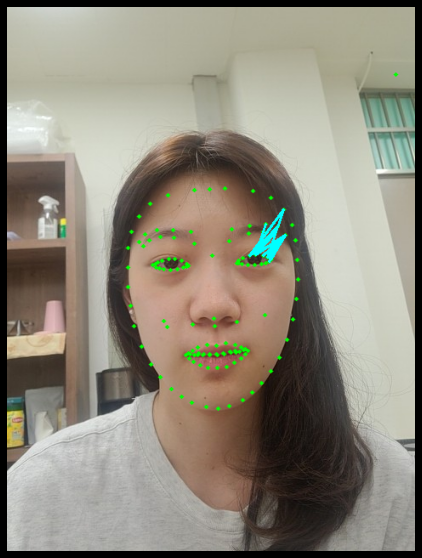

In [321]:
order = 28
print(cal_score_test(landmark_matrixs_df_test.iloc[order], len(importance_points)))
face = '눈썹올리기테스트'
diff_list_test, landmarks_cut_test = show_diff(test_landmark, 5)
diff_list_test = [x.split(' ↔ ') for x in importance.iloc[:16]['landmarks']]
image_order = order
show_img(landmarks_cut_test, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list_test)

## 입술안으로말아넣기

훈련세트 정확도: 0.985
테스트세트 정확도: 0.978
        landmarks  importance
800    0-6 ↔ 0-30        0.04
8026   7-5 ↔ 10-5        0.04
3932   0-34 ↔ 1-4        0.03
675    0-5 ↔ 0-31        0.03
3838   0-33 ↔ 2-3        0.03
...           ...         ...
2930   0-24 ↔ 5-7        0.00
2929   0-24 ↔ 5-6        0.00
2928   0-24 ↔ 5-5        0.00
2927   0-24 ↔ 5-4        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


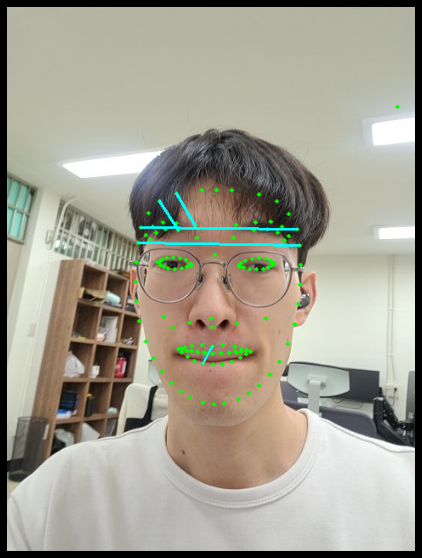

In [326]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입술안으로말아넣기+1/202209.21214438573.csv', 'rf')
face = '입술안으로말아넣기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [330]:
cal_score(landmark_matrixs_df.iloc[10], 15)

800 0.6176043654069433
8026 0.6603351592376675
3932 0.5834173911275391
675 0.5656410046456208
3838 0.6278495175920595
3739 0.609069227909799
182 0.5991928070934825
8596 0.5288487631811911
8204 0.6990733879086679
8164 0.7593808895316355
8315 0.6828009288967667
7940 0.5776288727026281
6754 0.6927565845104142
7891 0.8117085947170789
53 0.6457101576301711


0.6440678434727777

In [345]:
importance_points = ['7-4 ↔ 9-5', '7-5 ↔ 10-4', '7-6 ↔ 9-3', '7-7 ↔ 9-2',
                    '0-17 ↔ 7-4',]
cal_score_test(landmark_matrixs_df.iloc[15], len(importance_points))

7978 0.6528282493456159
8025 0.7130795083431456
8053 0.8838171578174665
8089 0.6345736972845849
2182 0.8491884105073264


0.7466974046596278

In [ ]:
for i in importance_points:
    a_list = landmark_matrixs_df[name_list.index(i)]
    b_list = landmark_matrixs_df2[name_list.index(i)]
    if a_list.mean() > b_list.mean():
            a = a_list.max()
            b = b_list.min()
    else:
        a = a_list.min()
        b = b_list.max()
    landmark_from = i.split('↔')[0]
    landmark_to = i.split('↔')[1]
    importance_landmark.loc[idx] = [landmark_from, landmark_to, a, b, '입술안으로말아넣기']
    idx += 1

## 입술끝올리기

훈련세트 정확도: 0.999
테스트세트 정확도: 1.000
        landmarks  importance
7995   7-4 ↔ 12-2        0.02
8680  10-1 ↔ 11-0        0.02
7228   6-4 ↔ 10-6        0.01
8108   7-7 ↔ 12-1        0.01
7852    7-1 ↔ 9-2        0.01
...           ...         ...
2920   0-24 ↔ 4-2        0.00
2919   0-24 ↔ 4-1        0.00
2918   0-24 ↔ 4-0        0.00
2917   0-24 ↔ 3-4        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


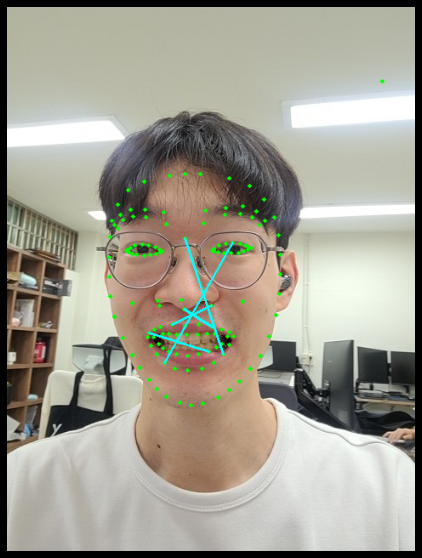

In [346]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입술끝올리기+1/202209.21213927539.csv', 'rf')
face = '입술끝올리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [347]:
## xgb_reg
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/입술끝올리기+1/202209.21213927539.csv'
# data_path2 = '../data/images/눈썹올리기테스트/202209.27223953510.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

rf_cls = RandomForestRegressor(bootstrap=True, random_state=2022, oob_score=True)

rf_cls.fit(X_train, y_train)
pred = rf_cls.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(rf_cls.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rf_cls.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': rf_cls.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
# test_df = pd.read_csv('../data/images/입벌리기+0.5/202209.15190045957.csv')
# landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
# landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
# print([format(x, '.8f') for x in xgb_reg.predict(landmark_matrixs_df_test)])

훈련세트 정확도: 0.999
테스트세트 정확도: 1.000
        landmarks  importance
7995   7-4 ↔ 12-2        0.02
8680  10-1 ↔ 11-0        0.02
7228   6-4 ↔ 10-6        0.01
8108   7-7 ↔ 12-1        0.01
7852    7-1 ↔ 9-2        0.01
...           ...         ...
2920   0-24 ↔ 4-2        0.00
2919   0-24 ↔ 4-1        0.00
2918   0-24 ↔ 4-0        0.00
2917   0-24 ↔ 3-4        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


In [351]:
importance.head(20)

,landmarks,importance
7995,7-4 ↔ 12-2,0.02
8680,10-1 ↔ 11-0,0.02
7228,6-4 ↔ 10-6,0.01
8108,7-7 ↔ 12-1,0.01
7852,7-1 ↔ 9-2,0.01
8086,7-7 ↔ 8-8,0.01
3651,0-31 ↔ 5-0,0.01
6665,5-11 ↔ 8-1,0.01
8661,10-0 ↔ 10-4,0.01
8282,8-2 ↔ 8-3,0.01


In [350]:
cal_score(landmark_matrixs_df2.iloc[10], 15)

7995 0.8232124825707231
8680 0.9486708054884725
7228 0.9737342527638266
8108 0.7531061502948478
7852 0.8364921685722434
8086 0.9133803453928516
3651 0.8417567010777056
6665 0.6976694790181767
8661 0.9064717092843632
8282 0.839551381151282
8536 0.8991223292170677
7859 0.8530154509606647
7735 0.9172881910301258
8392 0.8325709424643227
8102 0.8820689346770811


0.8612074215975837

In [367]:
importance_points = ['9-5 ↔ 12-0', '9-3 ↔ 12-2', '10-2 ↔ 12-0',
                     '10-6 ↔ 12-2', '7-4 ↔ 12-2', '7-6 ↔ 12-0']
cal_score_test(landmark_matrixs_df.iloc[20], len(importance_points))

8602 0.21402929346617736
8565 0.2689682357098452
8695 0.17814824704931373
8739 0.18570944594590286
7995 0.2941446304364441
8070 0.14003717683185796


0.2135061715732569

In [369]:
for i in importance_points:
    a_list = landmark_matrixs_df[name_list.index(i)]
    b_list = landmark_matrixs_df2[name_list.index(i)]
    if a_list.mean() > b_list.mean():
            a = a_list.max()
            b = b_list.min()
    else:
        a = a_list.min()
        b = b_list.max()
    landmark_from = i.split('↔')[0]
    landmark_to = i.split('↔')[1]
    importance_landmark.loc[idx] = [landmark_from, landmark_to, a, b, '입술끝올리기']
    idx += 1

In [359]:
test_landmark = pd.read_csv('../data/images/입술끝올리기테스트2/202209.27230411229.csv')
landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_landmark)
# landmark_matrixs_df_test['class'] = 1.0

8602 0.7318721405625142
8565 0.7515650607263787
8695 0.6880298973293149
8739 0.7596434167026496
7995 0.7790265877580642
8070 0.7994569048854587
0.7515990013273969


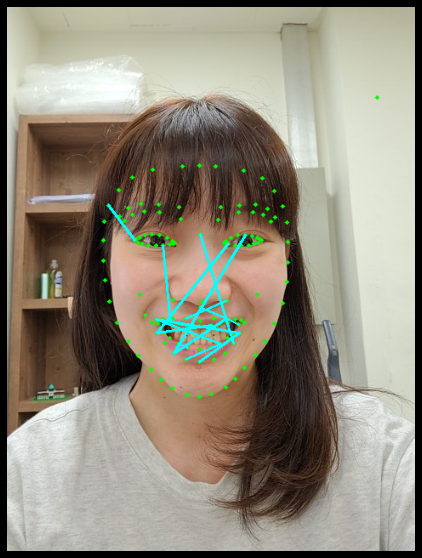

In [368]:
order = 8
print(cal_score_test(landmark_matrixs_df_test.iloc[order], len(importance_points)))
face = '입술끝올리기테스트2'
diff_list_test, landmarks_cut_test = show_diff(test_landmark, 5)
diff_list_test = [x.split(' ↔ ') for x in importance.iloc[:16]['landmarks']]
image_order = order
show_img(landmarks_cut_test, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list_test)

## 눈썹모으기

훈련세트 정확도: 0.994
테스트세트 정확도: 0.994
        landmarks  importance
5232    3-2 ↔ 6-1        0.03
4883   2-3 ↔ 5-10        0.02
5389    3-4 ↔ 5-9        0.02
4156   1-0 ↔ 5-15        0.02
5235    3-2 ↔ 6-4        0.02
...           ...         ...
2917   0-24 ↔ 3-4        0.00
2916   0-24 ↔ 3-3        0.00
2915   0-24 ↔ 3-2        0.00
2914   0-24 ↔ 3-1        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


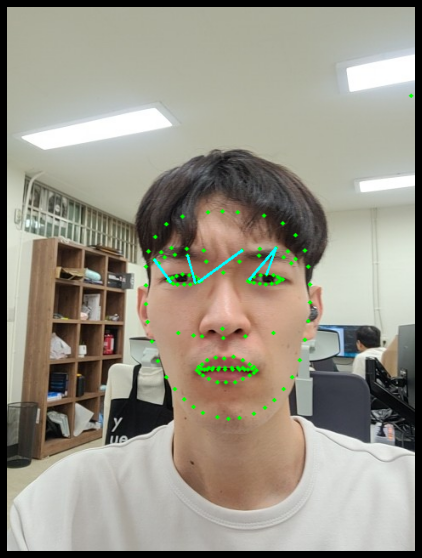

In [370]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/눈썹모으기+1/202209.21211916421.csv', 'rf')
face = '눈썹모으기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [379]:
## xgb_reg
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/눈썹모으기+1/202209.21211916421.csv'
# data_path2 = '../data/images/눈썹올리기테스트/202209.27223953510.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

rf_cls = RandomForestRegressor(bootstrap=True, random_state=2022, oob_score=True)

rf_cls.fit(X_train, y_train)
pred = rf_cls.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(rf_cls.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rf_cls.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': rf_cls.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
# test_df = pd.read_csv('../data/images/입벌리기+0.5/202209.15190045957.csv')
# landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
# landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
# print([format(x, '.8f') for x in xgb_reg.predict(landmark_matrixs_df_test)])

훈련세트 정확도: 0.994
테스트세트 정확도: 0.994
        landmarks  importance
5232    3-2 ↔ 6-1        0.03
4883   2-3 ↔ 5-10        0.02
5389    3-4 ↔ 5-9        0.02
4156   1-0 ↔ 5-15        0.02
5235    3-2 ↔ 6-4        0.02
...           ...         ...
2917   0-24 ↔ 3-4        0.00
2916   0-24 ↔ 3-3        0.00
2915   0-24 ↔ 3-2        0.00
2914   0-24 ↔ 3-1        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


In [380]:
cal_score(landmark_matrixs_df.iloc[10], 15)

5232 0.44978139716827814
4883 0.2923543880571734
5389 0.5084107950296852
4156 0.26361960235472315
5235 0.38472600558386294
4707 0.32577739769924124
5030 0.42486084864519835
4141 0.20402691393195677
5636 0.3853060159670819
4607 0.35823183654048985
5571 0.43247802583735934
470 0.39044758161598364
219 0.6270017725390588
4904 0.381411866661894
5441 0.5132663122035525


0.39611338398903595

In [384]:
importance_points = ['3-2 ↔ 6-1', '1-2 ↔ 5-7', '2-3 ↔ 5-10', '4-3 ↔ 6-14', '3-4 ↔ 5-9',
                     '1-4 ↔ 6-15', '3-4 ↔ 5-10']
cal_score_test(landmark_matrixs_df.iloc[20], len(importance_points))

5232 0.4709708299264045
4337 0.5305656637550928
4883 0.5172453780229503
5728 0.4396496047532225
5389 0.7222647976970067
4546 0.5328710218515438
5390 0.724351840315668


0.5625598766174127

In [385]:
for i in importance_points:
    a_list = landmark_matrixs_df[name_list.index(i)]
    b_list = landmark_matrixs_df2[name_list.index(i)]
    if a_list.mean() > b_list.mean():
            a = a_list.max()
            b = b_list.min()
    else:
        a = a_list.min()
        b = b_list.max()
    landmark_from = i.split('↔')[0]
    landmark_to = i.split('↔')[1]
    importance_landmark.loc[idx] = [landmark_from, landmark_to, a, b, '눈썹모으기']
    idx += 1

In [390]:
importance_landmark

,from,to,a,b,운동이름
0,0-0,6-15,0.399687,0.335968,눈깜빡감기
1,0-1,6-13,0.404032,0.330206,눈깜빡감기
2,0-2,6-11,0.374092,0.307623,눈깜빡감기
3,0-3,6-10,0.332697,0.274081,눈깜빡감기
4,0-4,6-8,0.251939,0.214232,눈깜빡감기
5,0-31,5-15,0.220694,0.172107,눈깜빡감기
6,0-32,5-13,0.298084,0.240316,눈깜빡감기
7,0-33,5-11,0.358580,0.291816,눈깜빡감기
8,0-34,5-10,0.373130,0.302967,눈깜빡감기
9,0-35,5-8,0.378366,0.312125,눈깜빡감기
